In [1]:
import warnings
warnings.filterwarnings('ignore')

from utils import Dataset, GraphsizePretrained
from tqdm import tqdm
from tqdm.notebook import tqdm
from time import time
import numpy as np

Using backend: pytorch


In [2]:
%%time
graph_builder = GraphsizePretrained(w=1, verbose=True,
                   pretrained_vec='/home/mangaravite/Documentos/pretrained_vectors/glove.6B.300d.txt')

400000it [00:22, 17764.26it/s]


CPU times: user 22.2 s, sys: 640 ms, total: 22.8 s
Wall time: 22.7 s


In [3]:
dataset = Dataset('/home/mangaravite/Documentos/datasets/classification/datasets/reut/')
fold = next(dataset.get_fold_instances(10, with_val=False))
fold._fields, len(fold.X_train)

(('X_train', 'y_train', 'X_test', 'y_test'), 11977)

In [4]:
import torch
import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
from dgl.nn.pytorch.conv import GraphConv, GATConv
from dgl.nn.pytorch.glob import GlobalAttentionPooling

from sklearn.preprocessing import LabelEncoder

from itertools import repeat

import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
%%time
graph_builder.fit(fold.X_train, fold.y_train)

100%|██████████| 11977/11977 [00:06<00:00, 1854.71it/s]


CPU times: user 7.91 s, sys: 87.9 ms, total: 8 s
Wall time: 7.98 s


GraphsizePretrained(pretrained_vec='/home/mangaravite/Documentos/pretrained_vectors/glove.6B.300d.txt',
                    verbose=None, w=1)

In [6]:
len(graph_builder.g.edges), len(graph_builder.g)

(174619, 24001)

In [7]:
list(map(lambda x: (x,graph_builder.g.degree()[x]), graph_builder.label_ids))

[(0, 275),
 (1, 77),
 (2, 525),
 (3, 2248),
 (4, 1302),
 (5, 650),
 (6, 2638),
 (7, 1165),
 (8, 1483),
 (9, 58),
 (10, 490),
 (11, 580),
 (12, 1537),
 (13, 1113),
 (14, 219),
 (15, 2257),
 (16, 6159),
 (17, 5771),
 (18, 3211),
 (19, 651),
 (20, 272),
 (21, 339),
 (22, 853),
 (23, 604),
 (24, 4536),
 (25, 794),
 (26, 3059),
 (27, 1841),
 (28, 835),
 (29, 1766),
 (30, 1953),
 (31, 6886),
 (32, 721),
 (33, 2124),
 (34, 433),
 (35, 108),
 (36, 431),
 (37, 719),
 (38, 113),
 (39, 11350),
 (40, 4884),
 (41, 9921),
 (42, 294),
 (43, 3537),
 (44, 2962),
 (45, 42),
 (46, 335),
 (47, 947),
 (48, 1233),
 (49, 514),
 (50, 188),
 (51, 641),
 (52, 6302),
 (53, 140),
 (54, 972),
 (55, 1785),
 (56, 498),
 (57, 1056),
 (58, 695),
 (59, 1442),
 (60, 1751),
 (61, 376),
 (62, 906),
 (63, 3476),
 (64, 553),
 (65, 372),
 (66, 455),
 (67, 2464),
 (68, 905),
 (69, 1357),
 (70, 545),
 (71, 3748),
 (72, 1700),
 (73, 1508),
 (74, 66),
 (75, 1001),
 (76, 3434),
 (77, 1909),
 (78, 479),
 (79, 877),
 (80, 260),
 (8

In [8]:
class GenericGAT(nn.Module):
    def __init__(self, in_dim, hidden_dim,
                 drop=.5, n_heads=8, attn_drop=.5,
                 activation=F.leaky_relu, n_convs=2,
                 first_hidden='emb', encoders={'term','label'},
                 device='cpu:0'):
        super(GenericGAT, self).__init__()
        self.device = torch.device(device)
        self.first_hidden = first_hidden
        
        self.encoders = nn.ModuleDict({
            k: nn.Linear(in_dim, hidden_dim).to(self.device) for k in encoders
        })
        
        self.layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim, residual=True, num_heads=n_heads, activation=activation,
                    feat_drop=drop, attn_drop=attn_drop).to(self.device) for _ in range(n_convs)
        ])
        self.down_proj = [
            nn.Linear(n_heads*hidden_dim, hidden_dim).to(self.device) for _ in range(n_convs)
        ]
        
    def forward(self, G, **kwargs):
        with G.local_scope():
            h = G.ndata[self.first_hidden].float()
            for (k, mask) in kwargs.items():
                if k in self.encoders:
                    if mask is not None:
                        h[ mask ] = self.encoders[k]( h[ mask ] )
                    else:
                        h = self.encoders[k]( h )

            for l, conv in enumerate(self.layers):
                h = conv(G, h)
                h = h.view(h.shape[0], -1)
                h = self.down_proj[l]( h )
                #h = F.relu( h )
        return h
        

In [9]:
g = nx.Graph()
g.add_node(1, weight=1)
g.nodes[1]['weight']

1

In [10]:
def collate(param):
    X, y = zip(*param)
    Gs_nx = graph_builder.transform(X)
    
    Gs_dgl_list = []
    for g in Gs_nx:
        g_dgl = dgl.DGLGraph()
        if len(g) > 0:
            g_dgl.from_networkx(g, node_attrs=['emb', 'idx'] )
        Gs_dgl_list.append( g_dgl )
    
    Gs_dgl = dgl.batch(Gs_dgl_list)
    
    big_graph_dgl = dgl.DGLGraph()
    big_graph_dgl.from_networkx(graph_builder.g, node_attrs=['emb', 'label', 'idx'] )
    
    #subgraph = graph_builder.g.subgraph(idx_terms)
    #big_graph_dgl.from_networkx(subgraph, node_attrs=['emb', 'label', 'idx'] )
    
    return big_graph_dgl, Gs_dgl, torch.tensor(y)

In [11]:
class CosineDistanceLoss(torch.nn.Module):
    def __init__(self, reduction='mean', alpha=-1.):
        super(CosineDistanceLoss, self).__init__()

        self.loss = nn.CosineEmbeddingLoss(reduction=reduction)
        self.alpha = alpha

    def forward(self, X, Y=None, y_idxs=None):
        nsmpl, ndims = X.shape
        A = []
        B = []
        target = []
        if Y is not None and y_idxs is not None:
            for (x,y_idx) in zip(X, y_idxs):
                for i,y in enumerate(Y):
                    A.append( x )
                    B.append( y )
                    target.append( 1 if i == y_idx.item() else -1 )
            
        else:
            for i in range(nsmpl):
                for j in range(i+1, nsmpl):
                    A.append( X[i] )
                    B.append( self.alpha*X[j] )
                    target.append( 1 )

        A=torch.cat(A).reshape( len(target), ndims ).to(X.device)
        B=torch.cat(B).reshape( len(target), ndims ).to(X.device)
        target=torch.Tensor(target).to(X.device)
            
        
        return self.loss(A, B, target=target)


In [12]:
class TGA(torch.nn.Module):
    def __init__(self, input_l, hidden_l, n_heads=1,
                drop=0.5, attn_drop=0.5,
                 device='cuda:0'):
        
        super(TGA, self).__init__()
        self.gat = GenericGAT( input_l, hidden_l, n_heads=n_heads,
                 drop=drop, attn_drop=attn_drop,
                 activation=None, device='cuda:0' ).to(device)
        self.norm = nn.BatchNorm1d(hidden_l).to(device)

        self.gate = nn.Linear( hidden_l, 1 ).to(device)
        self.feat = nn.Linear( hidden_l, hidden_l ).to(device)
        self.gap = GlobalAttentionPooling(self.gate, feat_nn=self.feat).to(device)

    def forward(self, G, gs, y, label_idx=None):
        if label_idx is None:
            label_idx = G.ndata['label'].nonzero().flatten()

        h_global = self.gat(G, label=label_idx, term=range(len(label_idx),len(graph_builder.g)))
        h_global = self.norm(h_global)

        labels_hiddens = h_global[label_idx]

        h_local = self.gap( gs, h_global[gs.ndata['idx'].reshape(-1)] )
        
        return h_local, h_global

In [13]:
hidden_l = 300
input_l = 300
n_heads = 2
drop=0.5
batch_size=128
attn_drop=0.5
device=torch.device('cuda:0')

In [14]:
tga = TGA(input_l, hidden_l, n_heads=n_heads, drop=drop, attn_drop=attn_drop).to(device)
tga

TGA(
  (gat): GenericGAT(
    (encoders): ModuleDict(
      (label): Linear(in_features=300, out_features=300, bias=True)
      (term): Linear(in_features=300, out_features=300, bias=True)
    )
    (layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=300, out_features=600, bias=False)
        (feat_drop): Dropout(p=0.5, inplace=False)
        (attn_drop): Dropout(p=0.5, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (res_fc): Identity()
      )
      (1): GATConv(
        (fc): Linear(in_features=300, out_features=600, bias=False)
        (feat_drop): Dropout(p=0.5, inplace=False)
        (attn_drop): Dropout(p=0.5, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (res_fc): Identity()
      )
    )
  )
  (norm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gate): Linear(in_features=300, out_features=1, bias=True)
  (feat): Linear(in_features=300, out_features=300, bias=Tr

In [15]:
loss_func_global = CosineDistanceLoss(reduction='mean', alpha=-1).to(device)
loss_func_local  = CosineDistanceLoss(reduction='mean').to(device)

optimizer = optim.AdamW( tga.parameters(), lr=5e-3, weight_decay=5e-3)


#RMSprop

In [16]:

best = None
nepochs = 5
lr = 2.*5e-2
l_loss = 0.
best_loss = None
best_loss_local = None
best_loss_global = None
for e in tqdm(range(nepochs), total=nepochs):
    epoch_loss = 0
    data_loader = DataLoader(list(zip(fold.X_train, fold.y_train)), batch_size=batch_size,
                             shuffle=True, collate_fn=collate, num_workers=3)
    with tqdm(total=len(fold.y_train)) as pbar:
        total = 1
        correct = 1
        tga.train()
        for G, gs, y in data_loader:
            G = G.to( device )
            gs = gs.to( device )
            y = y.to( device )
            
            h_local, h_global = tga( G, gs, y )
            
            label_idx = G.ndata['label'].nonzero().flatten()
            labels_hiddens = h_global[label_idx]
            
            loss_global = loss_func_global(labels_hiddens)
            
            loss_local = loss_func_local(h_local, labels_hiddens, y)
            
            
            loss = loss_global + loss_local
            loss.backward()

            optimizer.step()
            
            l_loss += loss.item()
    
            if best_loss_global is None or loss_global.item() < best_loss_global:
                best_loss = loss.item()
                best_loss_local = loss_local.item()
                best_loss_global = loss_global.item()
                best_h_global = h_global.cpu()
            
            
            to_print = f'local loss: {loss_local:.3}({best_loss_local:.3}), '
            to_print += f'global loss: {loss_global-1.:.3}({best_loss_global-1.:.3}), '
            to_print += f'loss: {(l_loss-1.)/(e+1):.3}({best_loss-1.:.3})             '
            
            print( to_print , end='\r')
            pbar.update( len(y) )
            pbar.set_description_str(f'iter {e} Loss: {(l_loss-1.)/(e+1):.6}')
            
            del loss, loss_local, loss_global, labels_hiddens, label_idx, G, gs, y, h_local, h_global

local loss: 0.0148(0.0358), global loss: 0.149(0.0578), loss: 1.1e+02(0.0936)              


local loss: 0.0135(0.0122), global loss: 0.113(0.0572), loss: 1.08e+02(0.0694)              


local loss: 0.028(0.0193), global loss: 0.0669(0.0411), loss: 1.07e+02(0.0604)              


local loss: 0.0207(0.0275), global loss: 0.073(0.0369), loss: 1.06e+02(0.0644)              


local loss: 0.0132(0.0275), global loss: 0.0577(0.0369), loss: 1.06e+02(0.0644)             



In [17]:
best_h_global

tensor([[ 0.8061, -0.3728,  2.1901,  ...,  0.6427, -1.9124,  0.2811],
        [ 0.8962, -0.4288,  2.1378,  ...,  0.6372, -1.8825,  0.4353],
        [-1.4246, -0.3673, -2.5209,  ...,  0.8990,  2.4280,  1.1058],
        ...,
        [-0.3726,  0.5411,  1.2325,  ...,  0.3574, -1.2548,  0.0472],
        [-0.3846,  0.5402,  1.2290,  ...,  0.3584, -1.2542,  0.0504],
        [-0.3802,  0.5399,  1.2323,  ...,  0.3561, -1.2493,  0.0437]],
       grad_fn=<CopyBackwards>)

In [18]:
big_graph_dgl = dgl.DGLGraph()
big_graph_dgl.from_networkx(graph_builder.g, node_attrs=['emb', 'label', 'idx'] )
label_idx = big_graph_dgl.ndata['label'].nonzero().flatten()


In [19]:
best_h_global[label_idx] # Embedding dos labels (Distâncias maximizadas)

tensor([[ 0.8061, -0.3728,  2.1901,  ...,  0.6427, -1.9124,  0.2811],
        [ 0.8962, -0.4288,  2.1378,  ...,  0.6372, -1.8825,  0.4353],
        [-1.4246, -0.3673, -2.5209,  ...,  0.8990,  2.4280,  1.1058],
        ...,
        [ 2.7684,  0.5976, -7.6698,  ..., -0.0221,  6.1107,  2.4819],
        [ 6.2269, -1.4882,  4.8718,  ...,  0.5947, -2.3928,  0.2692],
        [10.9429,  1.1316,  1.1029,  ...,  0.2289, -1.9813,  0.4709]],
       grad_fn=<IndexBackward>)

In [20]:
                        # embedding dos termos novos
best_h_global[len(label_idx):] # o mapeamento é (o inverso de) node_mapper[big_graph.ndata['idx']]

tensor([[-7.2342,  0.3449, -5.0977,  ...,  0.1898,  6.5882,  0.2931],
        [-6.4093, -0.4456,  1.3044,  ..., -0.4836,  6.3878, -5.4715],
        [-5.9600, -0.2419, -1.5119,  ..., -0.1797,  6.1696, -4.1197],
        ...,
        [-0.3726,  0.5411,  1.2325,  ...,  0.3574, -1.2548,  0.0472],
        [-0.3846,  0.5402,  1.2290,  ...,  0.3584, -1.2542,  0.0504],
        [-0.3802,  0.5399,  1.2323,  ...,  0.3561, -1.2493,  0.0437]],
       grad_fn=<SliceBackward>)

In [21]:
h_best[100:105]

NameError: name 'h_best' is not defined

In [ ]:
big_graph_dgl.ndata['emb'][100:105]

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

In [23]:
# Variância média DAS hidden dimensions dos labels &
#     -> O quanto as hidden estão variando entre as labels
#        Quanto maior esse valor, mais "diferente" são as representações dos LABELS
# Variância média ENTRE A MÉDIA DAS hidden dimensions dos labels
#     -> O quanto as hiddens estão variando entre si
#        Quanto maior esse valor, mais "diferente" são as representações das DIMENSÕES
#        Ou seja, VAR(AVG(h1), AVG(h2), ..., AVG(hn)) é alto
best_h_global[label_idx].std(axis=0).mean(), best_h_global[label_idx].mean(axis=0).std()

(tensor(2.4298, grad_fn=<MeanBackward0>),
 tensor(1.0926, grad_fn=<StdBackward0>))

In [24]:
nbins = 30

Text(0.5, 1.0, 'Labels\n[VAR(h1), VAR(h2), ..., VAR(hn)]')

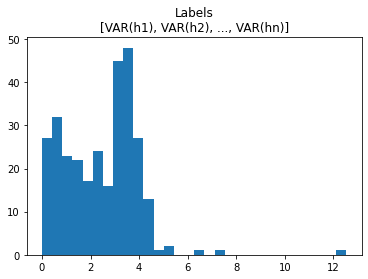

In [25]:
plt.hist( best_h_global[label_idx].std(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Labels\n[VAR(h1), VAR(h2), ..., VAR(hn)]' )

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=10, metric='cosine')
X = tsne.fit_transform(best_h_global.detach().cpu().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24001 samples in 0.007s...
[t-SNE] Computed neighbors for 24001 samples in 8.647s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24001
[t-SNE] Computed conditional probabilities for sample 2000 / 24001
[t-SNE] Computed conditional probabilities for sample 3000 / 24001
[t-SNE] Computed conditional probabilities for sample 4000 / 24001
[t-SNE] Computed conditional probabilities for sample 5000 / 24001
[t-SNE] Computed conditional probabilities for sample 6000 / 24001
[t-SNE] Computed conditional probabilities for sample 7000 / 24001
[t-SNE] Computed conditional probabilities for sample 8000 / 24001
[t-SNE] Computed conditional probabilities for sample 9000 / 24001
[t-SNE] Computed conditional probabilities for sample 10000 / 24001
[t-SNE] Computed conditional probabilities for sample 11000 / 24001
[t-SNE] Computed conditional probabilities for sample 12000 / 24001
[t-SNE] Computed conditional probabilities for sam

In [27]:
dataset.dname

'reut'

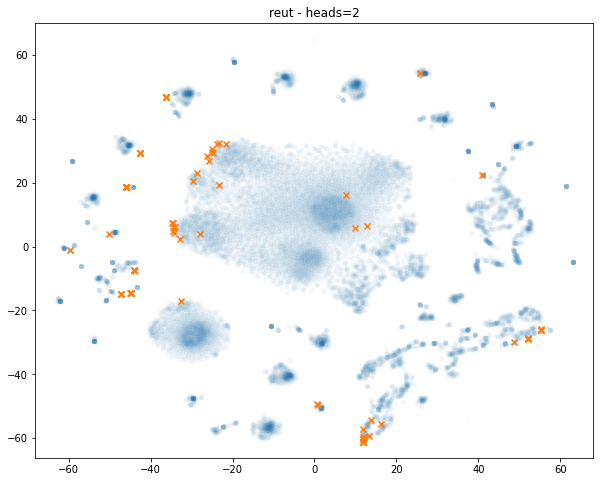

In [28]:
x,y = X.T
plt.figure(figsize=(10,8))
plt.scatter(x[len(label_idx):],y[len(label_idx):], linewidths= 0.0, s=25, alpha=0.025)
plt.scatter(x[label_idx.cpu().numpy()],y[label_idx.cpu().numpy()], marker='x')
plt.xlim( (x.min()-5, x.max()+5) )
plt.ylim( (y.min()-5, y.max()+5) )
plt.title(f'{dataset.dname} - heads={n_heads}')
plt.savefig(f'{dataset.dname}-heads={n_heads}_diff.png')

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=10)
X2 = tsne.fit_transform(big_graph_dgl.ndata['emb'][len(label_idx):].detach().cpu().numpy())

In [ ]:
x,y = X2.T
plt.scatter(x, y, linewidths= 0.0, alpha=0.01)
plt.xlim( (x.min()-5, x.max()+5) )
plt.ylim( (y.min()-5, y.max()+5) )

In [ ]:
x[label_idx.cpu().numpy()],y[label_idx.cpu().numpy()]

In [ ]:
plt.hist( h_best[len(label_idx):].std(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Terms\n[VAR(h1), VAR(h2), ..., VAR(hn)]' )

In [ ]:
plt.hist( h_best[label_idx].mean(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Labels\n[AVG(h1), AVG(h2), ..., AVG(hn)]' )

In [ ]:
plt.hist( h_best[len(label_idx):].mean(axis=0).detach().cpu().numpy(), bins=nbins )
plt.title( 'Terms\n[AVG(h1), AVG(h2), ..., AVG(hn)]' )

In [ ]:
label_idx = big_graph_dgl.ndata['label'].nonzero().flatten()

In [ ]:
h = gat(big_graph_dgl)
h.shape

In [ ]:
labels_hiddens = h[label_idx]
labels_hiddens

In [ ]:
A = []
B = []
y = []
for i in range(labels_hiddens.size()[0]):
    for j in range(labels_hiddens.size()[0]):
        if i != j:
            A.append( labels_hiddens[i] )
            B.append( -1.*labels_hiddens[j] )
            y.append( 1 )
            
B=torch.cat(B).reshape( len(y), 300 )
A=torch.cat(A).reshape( len(y), 300 )
y=torch.Tensor(y)

In [ ]:
loss_func(B, A, target=y), loss_func(A, B, target=y)

In [ ]:
gat.train()
torch.cuda.synchronize()

In [ ]:
class TGA(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_class,
                  n_heads=8, drop=.5, attn_drop=.5,
                  device='cuda:0'):
        super(TGA, self).__init__()
        self.n_class = n_class
        self.device = torch.device(device)
        self.gat_global = GenericGAT(in_dim, hidden_dim, 
                                     encoders={'label'}, 
                                     n_heads=n_heads, drop=drop,
                                     attn_drop=attn_drop, device=self.device)
        
        self.gat_local  = GenericGAT(hidden_dim, hidden_dim, 
                                     encoders={'term'}, 
                                     n_heads=n_heads, drop=drop,
                                     first_hidden='emb',
                                     attn_drop=attn_drop, device=self.device)

        self.lin = nn.Linear( hidden_dim, 1).to(self.device)
        # Depois tentar alguma ativação (ReLU, por exemplo, pode "desativar" alguns termos no softmax)
        self.pooling = GlobalAttentionPooling( self.lin ).to(self.device)

        # Fully Connected
        self.fc1 = nn.Linear( hidden_dim, hidden_dim//2).to(self.device)
        self.fc2 = nn.Linear( hidden_dim//2, hidden_dim//4).to(self.device)
        self.fc3 = nn.Linear( hidden_dim//4, self.n_class).to(self.device)
    def forward(self, G, gs):
        #h_global           = self.gat_global( G, label=G.ndata['label'].nonzero().flatten() )
        #gs.ndata['weight'] = h_global[ gs.ndata['idx'] ] # Tentar concatenando
        h_local            = self.gat_local(gs, term=None)
        #h_local            = torch.cat((h_local, h_global[ gs.ndata['idx'] ]), 1)
        h_local            = self.pooling( gs, h_local )
        h_local            = self.fc1( h_local )
        h_local            = self.fc2( h_local )
        h_local            = self.fc3( h_local )
        return h_local
# torch.Size([3652, 300]) torch.Size([3652, 300]) torch.Size([128, 300])
        

In [ ]:
in_dim=300
hidden_dim=2
n_heads=8
drop=0.3
attn_drop=0.5
batch_size=128
device='cuda:0'

In [ ]:
model = TGA( in_dim, hidden_dim, graph_builder.n_class,
            n_heads=n_heads, drop=drop, attn_drop=attn_drop )
model

In [ ]:
loss_func = nn.CrossEntropyLoss()

optimizer = optim.Adam( model.parameters(), lr=1e-3, weight_decay=1e-3)
#optimizer = optim.AdamW( model.parameters(), lr=1e-2, weight_decay=1e-3)

#optimizer = optim.RMSprop( model.parameters(), lr=1e-2, weight_decay=1e-4)
#optimizer = optim.RMSprop( model.parameters(), lr=0.0001 )

model.train()
torch.cuda.synchronize()

In [ ]:
g = nx.Graph()
g.add_nodes_from( [ (0, {'idx': 0}), (1, {'idx': 1}), (2, {'idx': 2}) ] )

In [ ]:
list(nx.get_node_attributes(g,'idx').values())

In [ ]:
outputs

In [ ]:
labels_hiddens = torch.eye( 11 )
labels_hiddens